<a href="https://colab.research.google.com/github/hexaquarks/PHYS339/blob/main/PHYS339_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Callibration

In [ ]:
import numpy as np

SAMPLES = 3
callibrationInputs = list(range(0,359,1))
callibrationInputs.append(359)

callibrationOutputs = [[] for y in range(SAMPLES)] 

for i in range(SAMPLES) :
  with open(f'PHYS339_Lab4_Callibration_Attempt{i+1}.txt', "r") as stream:
          for line in stream:
              currLine = line[15:].split(":")
              callibrationOutputs[i].append(int(currLine[1]))

callibrationSampleError = []
for i in range(SAMPLES):
  callibrationSampleError.append(np.sum(callibrationOutputs[i]) / len(callibrationInputs))

callibrationError = np.sum(callibrationSampleError) / SAMPLES
print(callibrationError)

FileNotFoundError: ignored

## Maus' Law Verification


In [ ]:
import numpy as np

SAMPLES = 5
mausInputs = list(range(0,359,1))
mausInputs.append(359)
mausInputsError = [ 0 for x in range(len(mausInputs))]
mausOutputs = [[] for y in range(SAMPLES)] 

for i in range(SAMPLES) :
  with open(f'PHYS339_Lab4_Maus_Attempt{i+1}.txt', "r") as stream:
          for line in stream:
              currLine = line[15:].split(":")
              mausOutputs[i].append(int(currLine[1]))

def standardization (arr):
  arr_out =  [np.mean([a,b,c,d,e]) for a,b,c,d,e in zip(*arr)]
  arr_out_error =  [np.std([a,b,c,d,e]) for a,b,c,d,e in zip(*arr)]                                                          
  return arr_out,arr_out_error

mausOutputs, mausOutputsError = standardization(mausOutputs)   

## Slicing the data to start at the first peek since first data points are bad
indexAtMax = mausOutputs.index(387.6)
mausInputs = mausInputs[indexAtMax:]
mausInputsError = mausInputsError[indexAtMax:]
mausOutputs = mausOutputs[indexAtMax:]
mausOutputsError = mausOutputsError[indexAtMax:]

print(mausOutputs)

## append the  noise error and the standard deviation error 
mausOutputsError = mausOutputsError + callibrationError

[387.6, 386.0, 383.4, 384.8, 382.8, 377.4, 375.8, 374.6, 374.2, 372.8, 372.6, 370.8, 370.4, 361.0, 356.0, 351.0, 347.4, 344.8, 334.0, 316.8, 318.2, 320.6, 327.2, 326.6, 320.4, 312.0, 308.4, 307.6, 308.4, 303.2, 296.6, 291.2, 286.2, 277.6, 269.6, 263.6, 253.6, 245.4, 235.4, 229.4, 222.0, 220.0, 213.8, 213.0, 210.6, 206.2, 200.6, 198.8, 195.8, 189.6, 180.2, 174.8, 168.8, 163.4, 157.4, 151.2, 145.8, 139.0, 133.4, 128.2, 123.2, 119.0, 114.0, 110.0, 104.2, 99.6, 94.6, 90.6, 85.6, 82.8, 75.4, 74.4, 71.6, 68.8, 65.2, 62.8, 60.4, 60.6, 55.8, 54.6, 54.4, 51.8, 50.2, 50.0, 49.2, 45.2, 47.8, 47.0, 46.6, 45.6, 46.0, 46.0, 46.4, 46.6, 47.4, 49.0, 50.6, 48.6, 54.0, 55.4, 57.8, 60.2, 63.2, 65.2, 68.0, 71.2, 75.6, 81.4, 82.6, 85.6, 90.8, 94.2, 99.0, 104.0, 110.0, 113.8, 118.0, 122.0, 129.0, 132.0, 135.2, 139.0, 144.8, 148.2, 152.0, 155.0, 161.2, 165.4, 176.4, 180.6, 190.2, 195.6, 205.4, 212.0, 220.8, 223.0, 221.6, 216.8, 230.4, 242.0, 252.8, 258.2, 264.6, 257.8, 264.0, 259.8, 259.0, 268.0, 279.4, 286.

### Converting bit values to volts

In [ ]:
def linearFit(x, m, b):
 return m*x + b

def convertBitsToVolts(outputs, m, b):
  outputs_arr = [linearFit(x, m, b) for x in outputs]
  return outputs_arr

def convertBitsToVoltsError(outputs,outputs_error, m, m_error, b, b_error):
  outputs_arr = [np.sqrt((x_error * m)**2 + (x*m_error)**2 + (b_error)**2) for x,x_error 
                 in zip(outputs,outputs_error)]
  return outputs_arr

m_10bit, m_10bit_error = 0.00491, 0.00001 #from last lab
b_10bit, b_10bit_error = 0.0486, 0.0007 #from last lab

mausOutputsCallibration = convertBitsToVolts(mausOutputs, m_10bit, b_10bit)
mausOutputsCallibrationError = convertBitsToVoltsError(
    mausOutputs, mausOutputsError, m_10bit,m_10bit_error, b_10bit, b_10bit_error
)

## Append the systematic errors and the random errors
mausOutputs = mausOutputsCallibration
mausOutputsError = mausOutputsCallibrationError

### Curve Fitting

In [ ]:
from scipy.optimize import curve_fit
from numpy import cos,sqrt,diag

#exponential fit
def cos2(x,a,x0,y0):
    return a*(cos(np.radians(x) + x0)**2) + y0

def least_squares_fit_parameters(
    inputs, 
    outputs, 
    outputs_error
):
    popt, pcov = curve_fit(
        cos2, 
        inputs, 
        outputs, 
        sigma=outputs_error,
        p0=(2, 0, 0.4)
    )
    perr = sqrt(diag(pcov))
    a, x0, y0 = popt
    a_error , x0_error, y0_error = perr
    return a, a_error, x0, x0_error, y0, y0_error

a,a_error, x0, x0_error, y0, y0_error = least_squares_fit_parameters(mausInputs, mausOutputs, mausOutputsError)
print(a)
print(a_error)
print(x0, x0_error)
print(y0)
print(y0_error)


-1.6229330318429511
0.0047542528536016265
-0.1728503871860167 0.0014820960145040076
1.8978567025114164
0.003676848051309503


### Residuals


In [ ]:
from numpy import cos, sin, sqrt

def fitResiduals(x, x_error, a,a_error, x0, x0_error, y0, y0_error):
     y = cos2(x,a,x0,y0)
     da = cos(x + x0)**2
     dx0 = -2*a*sin(x + x0)*cos(x + x0)
     dy0 = 1
     y_error = np.sqrt((da*a_error)**2 + (dx0*x0_error)**2 + (dy0 * y0_error)**2)
     return y, y_error
 
def residual(x, x_error,y,y_error, a,a_error, x0, x0_error, y0, y0_error):
     y_fit, y_fit_error = fitResiduals(x, x_error, a,a_error, x0, x0_error, y0, y0_error)
     return y - y_fit, y_error + y_fit_error 


## Fitting


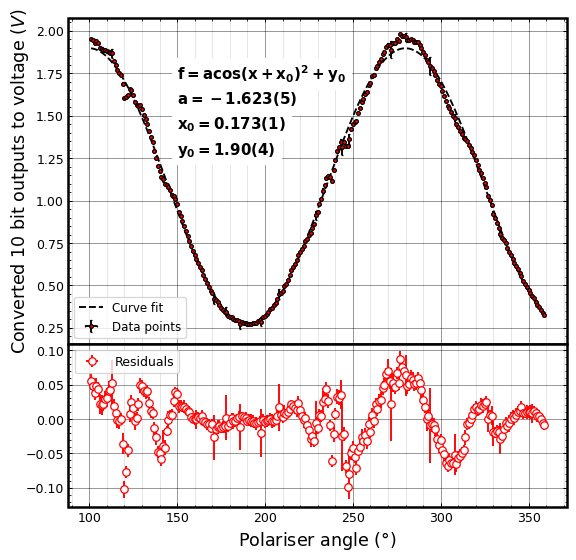

In [ ]:
import matplotlib.pyplot as plt

fig, (a0, a1) = plt.subplots(
     2,
     1,
     gridspec_kw={
     "height_ratios": [2, 1],
     "hspace": 0,
     },
     figsize=(6.5,6.5),
     dpi=90
)

fit_ys = [cos2(x,a,x0, y0) for x in mausInputs]

a0.errorbar(
    x=mausInputs,
    y=mausOutputs,
    xerr = mausInputsError,
    yerr = mausOutputsError,
    fmt='r.', ecolor="black",mec="black", capsize=1,
    label = "Data points")

a0.plot(
    mausInputs,
    fit_ys,
    '--',
    color='black',
    label="Curve fit")
#residual ploting


residuals, residuals_error = [
     list(values)
     for values in zip(*[
             residual(x, x_error, y, y_error, a, a_error, x0, x0_error, y0, y0_error)
             for x, x_error, y, y_error in zip(
                     mausInputs, mausInputsError,
                     mausOutputs, mausOutputsError
             )
     ])
]

a1.errorbar(
     mausInputs,
     residuals,
     xerr=mausInputsError,
     yerr=residuals_error,
     fmt="r.",
     marker="o",
     markerfacecolor="white",
     label="Residuals",
     color= "red"
)

a1.set_xlabel(r'Polariser angle $(\degree)$', fontsize=14)
a0.set_ylabel(r'Converted $10$ bit outputs to voltage $(V)$', fontsize = 14)

for ax in [a0, a1]:
  ax.patch.set_edgecolor('black')  
  ax.patch.set_linewidth('2') 
  ax.grid(b=True, which='major', color='black', alpha=0.4, linestyle='-')
  ax.grid(b=True, which='minor', axis='x', color='black', linestyle='-', alpha=0.1)
  ax.minorticks_on()

## ticks 
a0.tick_params(axis='x', which='both',
               direction="in", top=True,bottom=False)
a1.tick_params(axis='x', which='both',
               direction="in", top=False,bottom=True)

## legend
for a in [a0, a1]:
    legend = a.legend()
    legend.get_frame().set_linewidth(1.7)
    legend.get_frame().set_edgecolor("black")
    a.legend(loc="upper left")
    a.tick_params(axis='y',which='both',
               direction="in",right=True)
a0.legend(loc="lower left", fontsize=9.5)

## annotate plot
props = dict(facecolor='white', alpha=1, edgecolor='white')
a0.text(150, 1.75, r'$\bf{f = a} \bf{cos}\bf{(x+x_0)^2 + y_0}$', horizontalalignment='left', 
          verticalalignment='center', fontsize=12,bbox=props)
a0.text(150, 1.60, r'$\bf{a = -1.623(5)}$', horizontalalignment='left', 
          verticalalignment='center', fontsize=12,bbox=props)
a0.text(150, 1.45, r'$\bf{x_0 = 0.173(1)}$', horizontalalignment='left', 
          verticalalignment='center', fontsize=12,bbox=props)
a0.text(150, 1.30, r'$\bf{y_0 = 1.90(4)}$', horizontalalignment='left', 
          verticalalignment='center', fontsize=12,bbox=props)
fig.tight_layout()


## Brewster Angle

In [ ]:
import numpy as np

SAMPLES = 5
brewsterInputs = list(range(0,359,1))
brewsterInputs.append(359)
brewsterInputsError = [ 0 for x in range(len(brewsterInputs))]
brewsterOutputs = [[] for y in range(SAMPLES)] 

for i in range(SAMPLES) :
  with open(f'PHYS339_Lab4_Brewster_Attempt{i+1}.txt', "r") as stream:
          for line in stream:
              currLine = line[15:].split(":")
              brewsterOutputs[i].append(int(currLine[1]))

def standardization (arr):
  arrOut =  [np.mean([a,b,c,d,e]) for a,b,c,d,e in zip(*arr)]
  arrOutError =  [np.std([a,b,c,d,e]) for a,b,c,d,e in zip(*arr)]                                                          
  return arrOut,arrOutError

def localMaximaError (arr):
  firstMaxInputs = []
  secondMaxInputs = []
  for i in range(len(arr)):
    if(i == 1): continue
    middleIndex = int(len(arr[i])/2)
    middleIndex = middleIndex if middleIndex % 2 == 0 else middleIndex + 1
    firstSlice = arr[i][:middleIndex]
    secondSlice = arr[i][middleIndex:]
    firstMax, secondMax = [np.max(x) for x in [firstSlice,secondSlice]]
    indexAtFirstMax, indexAtSecondMax = [arr[i].index(x) for x in [firstMax, secondMax]]
    firstMaxInputs.append(brewsterInputs.index(indexAtFirstMax))
    secondMaxInputs.append(brewsterInputs.index(indexAtSecondMax))
  return np.std(firstMaxInputs) ,np.std(secondMaxInputs)

firstMaxInputError, secondMaxInputError = localMaximaError(brewsterOutputs)
brewsterOutputs, brewsterOutputsError = standardization(brewsterOutputs)
print(firstMaxInputError)
print(secondMaxInputError)

brewsterOutputs = [x / 650  for x in brewsterOutputs]
brewsterOutputsError = [x / 650  for x in brewsterOutputsError]
## 0.0 and 0.5, so the brewster angle is shifted by 3 degrees due to internal misconfiguration !!
## indeed in all files the local maximas occur at 87 degrees then 267 degrees with high
## degree of confidence, instead of 90 degrees and 270, respectively.


0.0
0.5


### Slicing the data from first local maxima to second local maxima

In [ ]:
# slicing the data 
indexAtFirstMax = brewsterOutputs.index(743.2/650)
indexAtSecondMax = brewsterOutputs.index(718/650)

In [ ]:
brewsterInputs = brewsterInputs[indexAtFirstMax:indexAtSecondMax]
brewsterInputsError = brewsterInputsError[indexAtFirstMax:indexAtSecondMax]
brewsterOutputs = brewsterOutputs[indexAtFirstMax:indexAtSecondMax]
brewsterOutputsError = brewsterOutputsError[indexAtFirstMax:indexAtSecondMax]

# mapping the x-axis values to degrees
DATASIZE = len(brewsterInputs)
DEGREES = 180
DEGSTEP = float((DATASIZE + 1) / DEGREES) # review here
print(DATASIZE)
print(DEGSTEP)

brewsterInputsFormatted = [ float(float(3) + (i * DEGSTEP)) for i in range(DATASIZE)]
print(brewsterInputsFormatted)
print(len(brewsterInputs))

179
1.0
[3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159

## Fitting to find the Brewster angle

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linspace

from scipy.optimize import curve_fit
from numpy import cos,sqrt,diag,sin, arcsin

n1, n1_error = 1.000293, 0.000001
n2, n2_error = 1.52, 0.01

beta, beta_error = (n2 / n1) , (sqrt(((1/n1)*n2_error)**2 + ((n2/n1**2) * n1_error)**2))

def thetaT(thetaI, thetaI_error):
  da = sin(thetaI) / (n2 * sqrt( 1- ((n1 * sin(thetaI))**2 / n2**2)))
  db = - n1 * sin(thetaI) / (n2**2 * sqrt(1 - ((n1 * sin(thetaI))**2 / n2**2)))
  dc = n1 * cos(thetaI) / (n2 * sqrt(1 - ((n1 * sin(thetaI))**2 / n2**2)))
  thetaT = arcsin((n1 / n2) * np.sin(thetaI))
  thetaT_error = sqrt((da*n1_error)**2 + (db * n2_error)**2 + (dc * thetaI_error)**2)
  return thetaT, thetaT_error

def alpha(thetaI, thetaI_error, thetaT, thetaT_error):
  I, T = thetaI, thetaT
  #a = thetaT
  da = - sin(T)*cos(T)*np.sec(I) / sqrt(1 - sin(T)**2)
  db = sqrt(1  - sin(T)**2) * np.tan(I) * np.sec(I)
  alpha = sqrt(1 - sin(T)**2) / cos(I)
  alpha_error = sqrt((da * thetaT_error)**2 + (db * thetaI_error)**2)
  return alpha, alpha_error

def brewster(thetaI, n2):
  thetaI = np.radians(thetaI - 70)
  al = sqrt(1 - ((n1/n2)*sin(thetaI))**2) / cos(thetaI)
  # al =  sqrt(1- sin(arcsin((n1/n2) * sin(thetaI)))**2) / cos(thetaI)
  return al * (n2 / n1) * (2 / (al + (n2 / n1)))**2

def brewsterTangent(n2, n2_error):
  dn1 = n2 / (n1**2 + n2**2)
  dn2 = - n1 / (n1 ** 2 + n2**2)
  angle = np.degrees(np.arctan(n2/n1))
  angle_error = np.degrees(sqrt((dn1 * n2_error)**2 + (dn2 * n1_error)**2))
  return angle, angle_error

#exponential fit
def cos2(x,a,x0,y0):
    return a*(cos(np.radians(x) + x0)**2) + y0

def least_squares_fit_parameters(
    inputs, 
    outputs, 
    outputs_error
):
    popt, pcov = curve_fit(
        brewster, 
        inputs, 
        outputs, 
        sigma=outputs_error,
        p0 = (1.5)
    )
    perr = sqrt(diag(pcov))
    n2 = popt
    n2_error = perr
    return n2, n2_error

 
def polyfitCoefficients(inputs, outputs, deg):
  return np.polyfit(inputs, outputs, deg, cov=True, full=False)

## slice the function for more precise fitting
FIT_START, FIT_END =70, 150
brewsterInputsFormattedFit = brewsterInputsFormatted[FIT_START:FIT_END]
brewsterOutputsFit = brewsterOutputs[FIT_START:FIT_END]
brewsterInputsErrorFit = brewsterInputsError[FIT_START:FIT_END]
brewsterOutputsErrorFit = brewsterOutputsError[FIT_START:FIT_END]

## New fit parameters
n2,n2_error = least_squares_fit_parameters(brewsterInputsFormattedFit, brewsterOutputsFit, brewsterOutputsErrorFit)
print(n2[0])
print(n2_error[0])

## Function parameters
poly1DFunction = np.poly1d(polyfitCoefficients(
    brewsterInputsFormattedFit, brewsterOutputsFit, 3)[0]
) 
## find the angle
xLinspace = linspace(FIT_START, FIT_END, 1000)
vals = [poly1DFunction(x) for x in xLinspace]
maxIndex = xLinspace[vals.index(np.max(vals))]
maxValue = np.max(vals)

brewsterAngle, brewsterAngleError = brewsterTangent(n2, n2_error)
print(brewsterAngle)
print(brewsterAngleError)

1.5609473446584297
0.02600125425938087
[57.34726401]
[0.67656203]


## Plotting Brewster's angle graphically

[3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


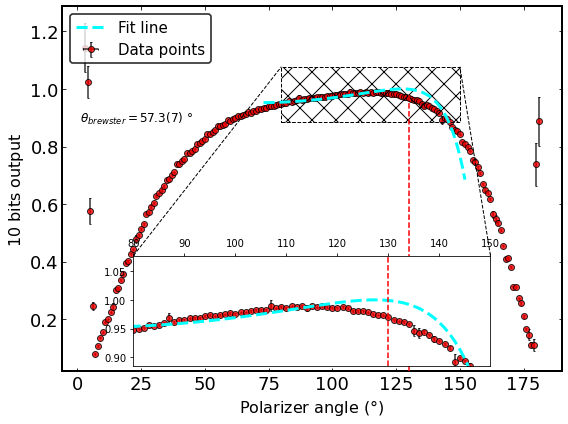

In [ ]:
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

fig, ax = plt.subplots(figsize=[8, 6])
fit_brewster = [brewster(x, n2[0]) for x in brewsterInputsFormattedFit]
print(brewsterInputsFormatted)
print(brewsterOutputs)

print(fit_brewster)
ax.errorbar(
    x=brewsterInputsFormatted,
    y=brewsterOutputs,
    xerr = brewsterInputsError,
    yerr = brewsterOutputsError,
    fmt='ro', ecolor="black",mec="black", capsize=1,
    label = "Data points", alpha=0.8, zorder=-100)
# ax.plot(brewsterInputsFormattedFit, poly1DFunction(brewsterInputsFormattedFit),
#          '--',color="cyan" ,linewidth=3, label="Fit line")
ax.plot(brewsterInputsFormattedFit, fit_brewster,
         '--',color="cyan" ,linewidth=3, label="Fit line")

# plotting the zoom inset
axins = zoomed_inset_axes(ax,2,loc="lower center")
axins.errorbar(
    x=brewsterInputsFormatted,
    y=brewsterOutputs,
    xerr = brewsterInputsError,
    yerr = brewsterOutputsError,
    fmt='ro', ecolor="black",mec="black", capsize=1,
    alpha=0.8, zorder=-100)

# axins.plot(brewsterInputsFormattedFit, poly1DFunction(brewsterInputsFormattedFit),
#          '--',color="cyan" ,linewidth=3)
axins.plot(brewsterInputsFormattedFit, fit_brewster,
         '--',color="cyan" ,linewidth=3)

x1,x2,y1,y2 = FIT_START+10, FIT_END, 575/650, 700/650

axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)
axins.xaxis.tick_top()
mark_inset(ax,axins,loc1=1,loc2=2, linewidth=1, hatch='x', linestyle='--')

## Plotting maximum occuring line
ax.axvline(x=130,ymin=0, ymax=(maxValue/(850/650)), linestyle='--',color="red")
axins.axvline(x=130, linestyle='--',color="red")

## ticks 
ax.tick_params(axis='y',
               direction="in",
               right=True, labelsize=18)
ax.tick_params(axis='x', direction="in" , top=True,bottom=True, labelsize=18)

## legends and utilities
ax.set_xlabel(r"Polarizer angle $(\degree)$", fontsize=16)
ax.set_ylabel(r"$10$ bits output", fontsize=16)
ax.legend(loc='upper left',fontsize=15)

## border colors
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2') 
legend = ax.get_legend()
legend.get_frame().set_linewidth(1.7)
legend.get_frame().set_edgecolor("black")

## annotate plot

ax.text(1, 0.9, r'$\theta_{brewster} = 57.3(7) \ \degree$', horizontalalignment='left', 
          verticalalignment='center', fontsize=12)

fig.tight_layout()


## Laser Response

In [ ]:
import numpy as np

SAMPLES = 4
laserInputs = list(range(0,359,1))
laserInputs.append(359)
laserInputs = laserInputs[2:]
laserInputsError = [ 0 for x in range(len(laserInputs))]
laserOutputs = [[] for y in range(SAMPLES)] 

for i in range(SAMPLES):
  with open(f'PHYS339_Lab4_2_2_Attempt{i+1}.txt', "r") as stream:
    for line in stream:
      currLine = line[15:].split(":")
      laserOutputs[i].append(int(currLine[1]))

def standardization (arr):
  arr_out =  [np.mean([a,b,c,d]) for a,b,c,d in zip(*arr)]
  arr_out_error =  [np.std([a,b,c,d]) for a,b,c,d in zip(*arr)]                                                          
  return arr_out,arr_out_error

laserOutputs, laserOutputsError = standardization(laserOutputs)   

m_10bit, m_10bit_error = 0.00491, 0.00001 #from last lab
b_10bit, b_10bit_error = 0.0486, 0.0007 #from last lab

laserOutputsCallibration = convertBitsToVolts(laserOutputs, m_10bit, b_10bit)
laserOutputsCallibrationError = convertBitsToVoltsError(
    laserOutputs, laserOutputsError, m_10bit,m_10bit_error, b_10bit, b_10bit_error
)

## Append the systematic errors and the random errors
laserOutputs = laserOutputsCallibration[2:]
laserOutputsError = laserOutputsCallibrationError[2:]
print(laserInputs)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 

## Finding the cutoff intensity ? 

In [ ]:
def slope(x1, x2, y1, y2):
  return abs((y2 - y1)/(x2 - x1))

STEEP_END = 160
INIT = 35
RANGE = [x + 120 for x in range(30)]  # 120, 150
vals, valsStd = [], []
SHIFT = [-5.75, 0.1]

def polyfitCoefficients(inputs, outputs, deg):
  return np.polyfit(inputs, outputs, deg, cov=True)

def residual(x, a, b, y):
  return abs((a * x + b) - y)

def fitError(x, x_error, a, a_error, b, b_error):
  return np.sqrt((a * x_error)**2 + (a_error * x)**2 + b_error**2)

def populate():
  for x in RANGE:
    linearFit, linearFitError = polyfitCoefficients(laserInputs[INIT:x], laserOutputs[INIT:x], 1)
    linearTotalResiduals = sum(residual(xs ,linearFit[0], linearFit[1], y) for
                       xs, y in zip(laserInputs[INIT:x], laserOutputs[INIT:x]))
    steepFit, steepFitError = polyfitCoefficients(laserInputs[x:STEEP_END], laserOutputs[x:STEEP_END], 1)
    steepTotalResiduals = sum(residual(xs ,steepFit[0], steepFit[1], y) for
                       xs, y in zip(laserInputs[x:STEEP_END], laserOutputs[x:STEEP_END]))
    linearFitError = [np.sqrt(linearFitError[0][0]), np.sqrt(linearFitError[1][1])]
    steepFitError = [np.sqrt(steepFitError[0][0]), np.sqrt(steepFitError[1][1])]    

    vals.append((x, abs(linearTotalResiduals - steepTotalResiduals)
                 , steepFit, steepFitError, linearFit, linearFitError))
    valsStd.append(abs(linearTotalResiduals - steepTotalResiduals))

def computeTurnOnCurrent():
  populate()
  x = (min(vals, key=lambda x:x[1]))
  ## turn on current error
  turnOnCurrent = x[0]
  turnOnCurrentError = fitError(x[0],np.std(valsStd), x[2][0], x[3][0], x[2][1], x[3][1])
  return turnOnCurrent, turnOnCurrentError

turnOnCurrent, turnOnCurrentError = computeTurnOnCurrent()
## for plotting lines
cutOff = (min(vals, key=lambda x:x[1]))
linearLinspace = linspace(2, 350 , 100)
steepLinspace = linspace(turnOnCurrent-15, 200 , 100)
fitSteep = [cutOff[2][0] * x + cutOff[3][0] + SHIFT[0] for x in steepLinspace]
fitLinear = [cutOff[4][0] * x + cutOff[5][0] + SHIFT[1] for x in linearLinspace]

print(turnOnCurrent)
print(turnOnCurrentError)


131
0.5183497042206004


## Plotting Laser Response

[0.952251394556744, 0.9523824291330036, 0.9525509691832511, 0.9527570634980094, 0.9530007700464113, 0.9532821549463021, 0.953601291217804, 0.9539582573050962, 0.9543531353483716, 0.9547860091848773, 0.9552569620546897, 0.9557660739832946, 0.9563134188091543, 0.9568990608201422, 0.9575230509580296, 0.958185422544975, 0.9588861864801971, 0.9596253258486047, 0.960402789876013, 0.9612184871576297, 0.9620722780776436, 0.9629639663278142, 0.9638932894219153, 0.9648599080904587, 0.9658633944262376, 0.9669032186356469, 0.9679787342332219, 0.9690891614971853, 0.9702335689816876, 0.9714108528565186, 0.9726197138170734, 0.9738586312757289, 0.9751258345101642, 0.9764192704038918, 0.9777365673687837, 0.9790749949878995, 0.9804314188586832, 0.9818022500505037, 0.9831833885156368, 0.9845701597076402, 0.985957243564338, 0.9873385949024656, 0.9887073541455028, 0.9900557471629635, 0.9913749728357318, 0.9926550767747488, 0.993884809405752, 0.9950514663865221, 0.9961407090400404, 0.9971363621611482, 0.998

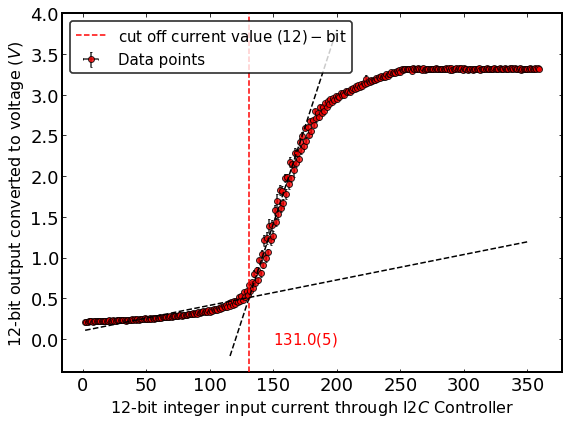

In [ ]:
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

fig, ax = plt.subplots(figsize=[8, 6])

print(fit_brewster)
ax.errorbar(
    x=laserInputs,
    y=laserOutputs,
    xerr = laserInputsError,
    yerr = laserOutputsError,
    fmt='ro', ecolor="black",mec="black", capsize=1,
    label = "Data points", alpha=0.8, zorder=-100)

## Turn on current
ax.axvline(x=turnOnCurrent,ymin=0, ymax=3.3, linestyle='--',color="red", label=r'cut off current value $(12)-$bit')
ax.plot(linearLinspace, fitLinear, '--', color="black")
ax.plot(steepLinspace, fitSteep, '--', color="black")

## ticks 
ax.tick_params(axis='y',
               direction="in",
               right=True, labelsize=18)
ax.tick_params(axis='x', direction="in" , top=True,bottom=True, labelsize=18)

## legends and utilities
ax.set_xlabel(r"$12$-bit integer input current through l$2C$ Controller ", fontsize=16)
ax.set_ylabel(r"$12$-bit output converted to voltage $(V)$", fontsize=16)
ax.legend(loc='upper left',fontsize=15)

## border colors
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2') 
legend = ax.get_legend()
legend.get_frame().set_linewidth(1.7)
legend.get_frame().set_edgecolor("black")

## Annotation
ax.text(150, 0, r'$131.0(5)$', horizontalalignment='left', 
          verticalalignment='center',color="red", fontsize=15)

fig.tight_layout()
